In [2]:
%reset
import sys
sys.path.append('../../')
import numpy as np
import pandas as pd
import datetime
from tsa import UVariateTimeSeriesClass
from tsa import UVariateTimeSeriesForecaster
from tsa import ProphetForecaster
from tsa import ARIMAForecaster
from tsa import SARIMAForecaster
from tsa import AutoARIMAForecaster
from tsa import LinearForecaster
from tsa import ExponentialSmoothingForecaster
from tsa import DLMForecaster
from tsa import EnsembleForecaster
from tsa import GridSearchClass
#from plotly.plotly import plot_mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
%matplotlib inline
from random import sample

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


##### Read in the data

In [3]:
try:
    ts_univ = pd.read_csv('../../data/AAPL.csv', index_col='Date', usecols=['Date','Adj Close'], parse_dates=True)
    time_format = "%Y-%m-%d"
    freq= 'D' 
    
    print ( "====================================\nData: data of shape " + str(ts_univ.shape) + " has been read in." ) 
except IOError as e:
    print("Could not read in the data: {}".format(e))

Data: data of shape (4475, 1) has been read in.


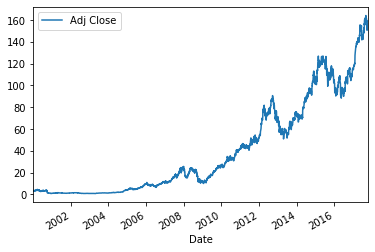

In [4]:
ts_univ.plot()

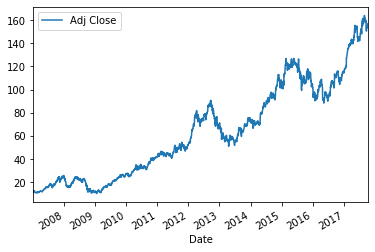

In [5]:
ts_univ = ts_univ[ts_univ.index >= datetime.datetime.strptime("2007-01-01", time_format)]
ts_univ.plot()

##### Basic Class: UVariateTimeSeriesClass

In [ ]:
uvts_cls = UVariateTimeSeriesClass(ts_df=ts_univ, time_format=time_format, freq=freq, fill_method='ffill')
plt.plot(uvts_cls.ts_df)

In [ ]:
uvts_cls.ts_decompose(params={'model':'additive',
                              'from': '2012-01-01',
                               'to' : '2012-01-15'})
uvts_cls.plot_decompose()

##### SARIMA Forecaster

In [10]:
tsf_obj = SARIMAForecaster(ts_df=ts_univ, time_format=time_format, freq=freq, fill_method='ffill',
                           n_test=365, n_val=180,
                           hyper_params = {
                                           'order': [(1,1,1), (0,1,0)],
                                           's_order': [(0,0,0,12), (0,1,0,12)],
                                           'trend': ['linear']
                           })                            

2019-10-24 17:32:53,120 | uvts_cls | INFO : Received time series data of range: 2007-01-03 00:00:00 - 2017-10-13 00:00:00 and shape: (2716, 1)
2019-10-24 17:32:53,129 | uvts_cls | INFO : Time series resampled at frequency: <Day>. New shape of the data: (3937, 1)
2019-10-24 17:32:53,138 | uvts_cls | INFO : Using time series data of range: 2007-01-03 00:00:00 - 2017-10-13 00:00:00 and shape: (3937, 1)


##### Prophet Forecaster

In [ ]:
tsf_obj = ProphetForecaster(ts_df=ts_univ, time_format=time_format, freq=freq, fill_method='ffill',
                            n_test=365, n_val=180,
                            hyper_params = {
                                            'prophet_interval_width': [0.95],
                                            'yearly_seasonality': [True, False],
                                            'weekly_seasonality': [True, False],
                                            'monthly_seasonality': [False],
                                            'quarterly_seasonality': [False],
                                            'daily_seasonality': [True],
                                            'weekend_seasonality': [False],
                                            'changepoint_prior_scale': [0.001],
                                            'consider_holidays': [False],
                                            'country':['US'],
                                            'diagnose':False})                            
"""
                            n_test=960, n_val=480,
                            prophet_interval_width=0.95,
                            yearly_seasonality=True,
                            weekly_seasonality=True,
                            monthly_seasonality=False,
                            quarterly_seasonality=False,
                            daily_seasonality=True,
                            weekend_seasonality=False,
                            changepoint_prior_scale=0.001,
                            consider_holidays=False,
                            country='US',
                            diagnose=True,
                            history='1460 days',
                            horizon='365 days',
                            step='180 days')
"""                            

##### Ensemble Forecaster

In [ ]:
tsf_obj = EnsembleForecaster(ensemble=['dlm', 'linear'], show_plots=True,
                             ts_df=ts_univ, time_format=time_format, freq=freq, n_test=12, n_val=6,
                             trend='constant linear',
                             dict_hyper_params={'linear': {'fit_intercept': [True, False]},
                                                'dlm': {'dlm_trend': [{'degree': 1, 'discount': 0.99, 'name': 'trend1', 'w': 5}, 
                                                                      {'degree': 1, 'discount': 0.7, 'name': 'trend1', 'w': 5},
                                                                     {'degree': 0, 'discount': 0.99, 'name': 'trend2', 'w': 5}],
                                                        'dlm_seasonality': [{'period': 12, 'discount': 0.95, 'name': 'seas1', 'w': 10},
                                                                           {'period': 12, 'discount': 0.99, 'name': 'seas2', 'w': 1}]}  
                                                
                                               },
                             dlm_trend={'degree': 1, 'discount': 0.99, 'name': 'trend1', 'w': 5},
                             dlm_seasonality = {'period': 12, 'discount': 0.95, 'name': 'seas1', 'w': 10},
                             dlm_auto_reg = {'degree': 2, 'discount': 0.95, 'name': 'autoreg1', 'w': 1},
                             fit_intercept=True)                                       

EnsembleForecaster.__mro__ #Method Resolution Order

##### UVariateTimeSeriesForecaster

In [ ]:
tsf_obj = UVariateTimeSeriesForecaster(forecasters=['prophet', 'auto_arima', 'arima', 'dlm', 'exponential smoothing'],
                                       ts_df=ts_univ, time_format=time_format, freq=freq, n_test=365,
                                       trend='constant linear',
                                       seasonal_periods=7,
                                       seasonal=True,
                                       max_p=2,
                                       max_q=2,
                                       max_Q=2,
                                       max_P=2,
                                       #d=0,
                                       order = (1,0,1),
                                       #s_order = (1, 0, 2, 7),
                                       dlm_trend={'degree': 1, 'discount': 0.7, 'name': 'trend1', 'w': 5},
                                       dlm_seasonality = {'period': 7, 'discount': 0.7, 'name': 'seas1', 'w': 10},
                                       prophet_interval_width=0.95,
                                       yearly_seasonality=True,
                                       weekly_seasonality=True,
                                       monthly_seasonality=False,
                                       quarterly_seasonality=False,
                                       daily_seasonality=True,
                                       weekend_seasonality=False,
                                       changepoint_prior_scale=0.001,
                                       consider_holidays=False,
                                       country='US',
                                       diagnose=False)                                       

#UVariateTimeSeriesForecaster.__mro__ #Method Resolution Order
#einstellung - ffill oder interpolated value

In [22]:
tsf_obj.ts_transform(transform='log10').ts_fit(suppress=True) 

2019-10-24 17:39:59,660 | ExpSmoothing | INFO : ***** Starting grid search *****
2019-10-24 17:39:59,662 | grid_search | INFO : 16 number of parameter combinations generated
2019-10-24 17:39:59,664 | grid_search | INFO : Hyper parameter set: 
....................... | grid_search | INFO : trend : add
....................... | grid_search | INFO : seasonal : add
....................... | grid_search | INFO : smoothing_level : 0.7
....................... | grid_search | INFO : smoothing_slope : 0.6

2019-10-24 17:39:59,667 | grid_search | INFO : Parameter type mismatch found, however, conversion successful
2019-10-24 17:39:59,669 | grid_search | INFO : Parameter type mismatch found, however, conversion successful
2019-10-24 17:39:59,672 | grid_search | INFO : Parameter type mismatch found, however, conversion successful
2019-10-24 17:39:59,674 | grid_search | INFO : Parameter type mismatch found, however, conversion successful
Trying to fit the exponential smoothing model....
2019-10-24 

C:\anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning:

overflow encountered in square



2019-10-24 17:40:01,593 | ExpSmoothing | INFO : Time elapsed: 0.07567739486694336 sec.
2019-10-24 17:40:01,595 | ExpSmoothing | INFO : Model successfully fitted to the data!
2019-10-24 17:40:01,596 | ExpSmoothing | INFO : Computing fitted values and residuals...
2019-10-24 17:40:01,600 | ExpSmoothing | INFO : Done.
2019-10-24 17:40:01,602 | ExpSmoothing | INFO : Evaluating the fitted model on the test data...
2019-10-24 17:40:01,690 | ExpSmoothing | INFO : RMSE on test data: inf
2019-10-24 17:40:01,692 | grid_search | INFO : Hyper parameter set: 
....................... | grid_search | INFO : trend : mul
....................... | grid_search | INFO : seasonal : add
....................... | grid_search | INFO : smoothing_level : 0.9
....................... | grid_search | INFO : smoothing_slope : 0.8

Trying to fit the exponential smoothing model....
2019-10-24 17:40:01,766 | ExpSmoothing | INFO : Time elapsed: 0.06671667098999023 sec.
2019-10-24 17:40:01,767 | ExpSmoothing | INFO : Mo

C:\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:893: RuntimeWarning:

overflow encountered in power

C:\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:894: RuntimeWarning:

overflow encountered in multiply



Trying to fit the exponential smoothing model....
2019-10-24 17:40:01,926 | ExpSmoothing | INFO : Time elapsed: 0.0701897144317627 sec.
2019-10-24 17:40:01,928 | ExpSmoothing | INFO : Model successfully fitted to the data!
2019-10-24 17:40:01,930 | ExpSmoothing | INFO : Computing fitted values and residuals...
2019-10-24 17:40:01,934 | ExpSmoothing | INFO : Done.
2019-10-24 17:40:01,936 | ExpSmoothing | INFO : Evaluating the fitted model on the test data...
2019-10-24 17:40:02,018 | ExpSmoothing | INFO : RMSE on test data: inf
2019-10-24 17:40:02,020 | grid_search | INFO : Hyper parameter set: 
....................... | grid_search | INFO : trend : mul
....................... | grid_search | INFO : seasonal : mul
....................... | grid_search | INFO : smoothing_level : 0.7
....................... | grid_search | INFO : smoothing_slope : 0.8

Trying to fit the exponential smoothing model....
2019-10-24 17:40:02,102 | ExpSmoothing | INFO : Time elapsed: 0.07621145248413086 sec.
2

C:\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:874: RuntimeWarning:

overflow encountered in power



Trying to fit the exponential smoothing model....
2019-10-24 17:40:02,286 | ExpSmoothing | INFO : Time elapsed: 0.08923888206481934 sec.
2019-10-24 17:40:02,288 | ExpSmoothing | INFO : Model successfully fitted to the data!
2019-10-24 17:40:02,289 | ExpSmoothing | INFO : Computing fitted values and residuals...
2019-10-24 17:40:02,294 | ExpSmoothing | INFO : Done.
2019-10-24 17:40:02,295 | ExpSmoothing | INFO : Evaluating the fitted model on the test data...
2019-10-24 17:40:02,367 | ExpSmoothing | INFO : RMSE on test data: 2.0459596118339016
2019-10-24 17:40:02,368 | grid_search | INFO : Hyper parameter set: 
....................... | grid_search | INFO : trend : mul
....................... | grid_search | INFO : seasonal : mul
....................... | grid_search | INFO : smoothing_level : 0.9
....................... | grid_search | INFO : smoothing_slope : 0.8

Trying to fit the exponential smoothing model....
2019-10-24 17:40:02,448 | ExpSmoothing | INFO : Time elapsed: 0.07319760

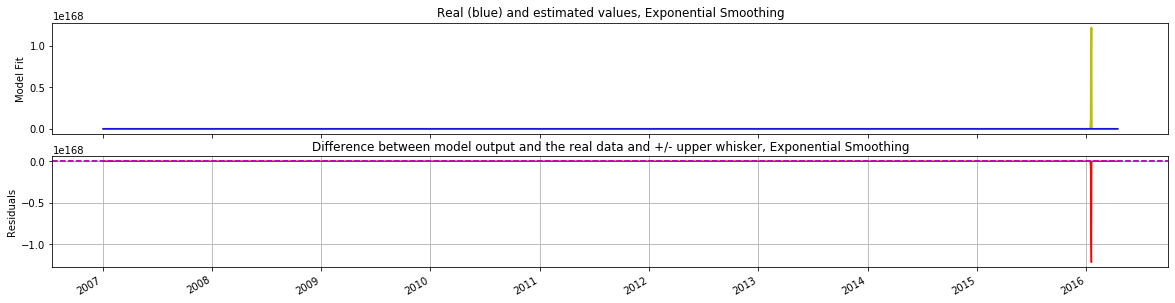

In [23]:
tsf_obj.ts_diagnose()

In [ ]:
tsf_obj.plot_residuals()

2019-10-24 17:40:30,890 | ExpSmoothing | INFO : Evaluating the fitted model on the test data...
2019-10-24 17:40:30,969 | ExpSmoothing | INFO : RMSE on test data: 2.0459596118339016


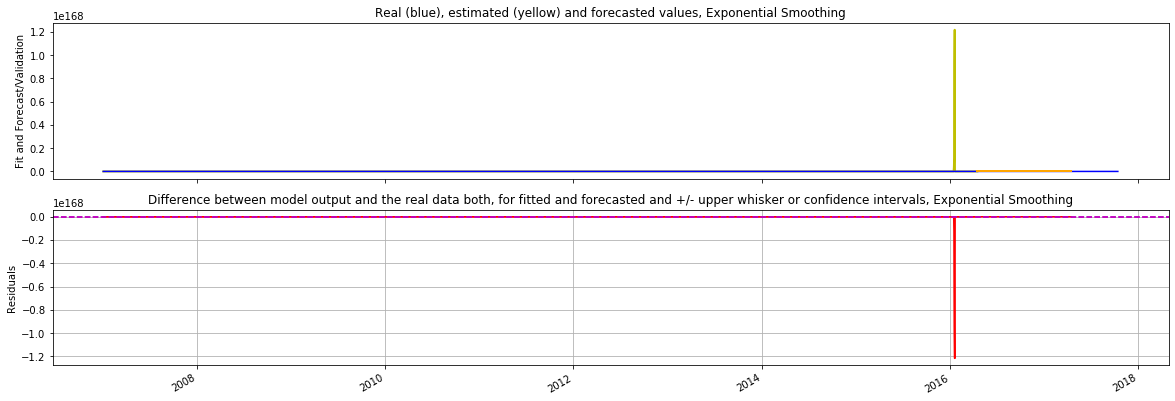

In [24]:
tsf_obj.ts_test(show_plot=True)

In [ ]:
tsf_obj.ts_validate(show_plot=True)

In [ ]:
tsf_obj.ts_forecast(n_forecast = 60, suppress=False)